In [208]:
import pandas as pd
import glob
from datetime import datetime
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [209]:
def simple_read(path):
    '''
    Reads .ict files to a Pandas DataFrame
    :param path: path to the .ict data
    :return: Pandas DataFrame with .ict data
    '''
    with open(path) as f:
        # find the value in the file which tells you how many lines to skip to get to the table
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
    data = pd.read_csv(path, sep=',', skiprows=header_line)

    # finds the location in the path containing the date
    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
        
    # creates datetime object with the date the data was collected
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8])) 
    
    for column in data.keys():
        if 'Time' in column:
            # converts seconds after midnight columns to datetime
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    data.columns = data.columns.str.replace(' ', '')
    data = data.replace(-8888, np.nan)
    return data.replace(-9999, np.nan) # Converts -9999 values to NaN

In [210]:
pils_paths = sorted(glob.glob('../data/*PILS*'))
master_pils = []
for i in range(0, len(pils_paths)):
    master_pils.append(simple_read(pils_paths[i]))
master_pils = pd.concat(master_pils).reset_index()

In [211]:
m = pd.read_csv('../tables/merged_final_non_org_fixed.csv', parse_dates=['Time_Mid'])

In [212]:
def process_row(i):
    # finds the mean/median/max using the SMPS start and end times (because that has the lowest time resolution)
    row = master_pils.iloc[i]
    t_start = row['Time_Start']
    t_stop = row['Time_Stop']
    m_row = m[(m['Time_Mid'] >= t_start) & (m['Time_Mid'] <= t_stop)].median(numeric_only=True)
    return m_row

results = Parallel(n_jobs=-1)(delayed(process_row)(i) for i in tqdm(range(0, len(master_pils))))

100%|██████████| 4665/4665 [00:00<00:00, 7555.50it/s]


In [213]:
m = pd.DataFrame(list(results))

In [214]:
d = pd.merge(m, master_pils[['Time_Mid', 'Sodium', 'Potassium',
       'Magnesium', 'Calcium', 'Chloride', 'Nitrate', 'Sulfate', 'Oxalate',
       'Ammonium']], left_index=True, right_index=True)

In [215]:
# Assuming 'd' is your DataFrame
# List of columns to process
columns_to_check = ['Sodium', 'Potassium', 'Magnesium', 'Calcium', 'Chloride', 'Nitrate', 'Sulfate', 'Oxalate', 'Ammonium']

# Replace values below zero with NaN
d[columns_to_check] = d[columns_to_check].map(lambda x: np.nan if x < 0 else x)

In [216]:
# Assuming 'd' is your DataFrame
# Calculate PILS_tot
d['PILS_tot'] = d[['Sodium', 'Potassium', 'Magnesium', 'Calcium', 'Chloride', 'Nitrate', 'Sulfate', 'Oxalate', 'Ammonium']].sum(axis=1)
# Calculate mass fractions for each species
d['Na_mf'] = d['Sodium'] / d['PILS_tot']  # Sodium mass fraction
d['K_mf'] = d['Potassium'] / d['PILS_tot']  # Potassium mass fraction
d['Mg_mf'] = d['Magnesium'] / d['PILS_tot']  # Magnesium mass fraction
d['Ca_mf'] = d['Calcium'] / d['PILS_tot']  # Calcium mass fraction
d['Cl_mf'] = d['Chloride'] / d['PILS_tot']  # Chloride mass fraction
d['NO3_mf'] = d['Nitrate'] / d['PILS_tot']  # Nitrate mass fraction
d['SO4_mf'] = d['Sulfate'] / d['PILS_tot']  # Sulfate mass fraction
d['Ox_mf'] = d['Oxalate'] / d['PILS_tot']  # Oxalate mass fraction
d['NH4_mf'] = d['Ammonium'] / d['PILS_tot']  # Ammonium mass fraction

# Calculate SeaSalt with fractional contributions, ensuring they do not exceed measured values
d['SeaSalt'] = (
    d['Sodium'] + d['Chloride'] + d['Magnesium'] +
    np.minimum(0.0375 * d['Sodium'], d['Potassium']) +  # Ensure fractional K+ ≤ measured K+
    np.minimum(0.04 * d['Sodium'], d['Calcium']) +       # Ensure fractional Ca2+ ≤ measured Ca2+
    np.minimum(0.25 * d['Sodium'], d['Sulfate'])         # Ensure fractional SO4²⁻ ≤ measured SO4²⁻
)

# Calculate SeaSalt_mf, handling division by zero
d['SeaSalt_mf'] = np.where(
    d['PILS_tot'] > 0,  # Check if PILS_tot is greater than zero
    d['SeaSalt'] / d['PILS_tot'],  # Compute mass fraction
    np.nan  # If PILS_tot is zero, set SeaSalt_mf to NaN
)
d['Ca_nssmf'] = np.where(
    d['PILS_tot'] > 0,  # Check if PILS_tot is greater than zero
    (d['Calcium'] - np.minimum(0.04 * d['Sodium'], d['Calcium'])) / d['PILS_tot'],  # Compute mass fraction
    np.nan  # If PILS_tot is zero, set SeaSalt_mf to NaN
)




In [217]:
transit_flights = [pd.Timestamp('2022-03-22').date(), pd.Timestamp('2022-05-18').date(), pd.Timestamp('2022-05-21').date(), pd.Timestamp('2022-05-31').date(), pd.Timestamp('2022-06-18').date()]
d.loc[d['Time_Mid'].dt.month.isin([11, 12, 1, 2, 3, 4]) & (~d['Time_Mid'].dt.date.isin(transit_flights)), 'Season'] = 'Winter'
d.loc[d['Time_Mid'].dt.month.isin([5, 6]) & (np.logical_not((d['Time_Mid'].dt.month.isin([6])) & (d['Time_Mid'].dt.year.isin([2022])))) & (~d['Time_Mid'].dt.date.isin(transit_flights)), 'Season'] = 'Spring'
d.loc[d['Time_Mid'].dt.month.isin([8, 9]) & (~d['Time_Mid'].dt.date.isin(transit_flights)), 'Season'] = 'Summer'
d.loc[(d['Time_Mid'].dt.month.isin([6])) & (d['Time_Mid'].dt.year.isin([2022])) & (~d['Time_Mid'].dt.date.isin(transit_flights)), 'Season'] = 'Bermuda'

In [218]:
d.to_csv('../tables/PILS_merged.csv', index=False)

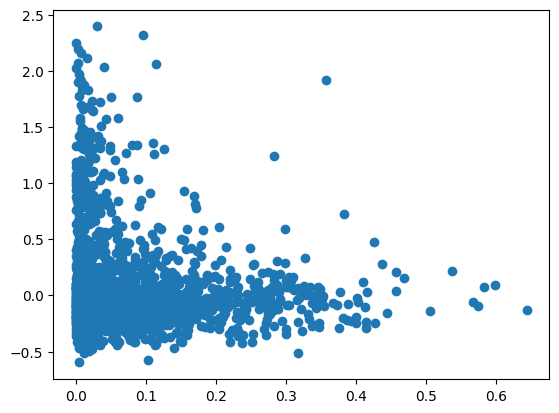

In [219]:
plt.scatter(d['Ca_mf'], d['k_obs'] - d['k'])

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_71438/4062001080.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Season', y='SeaSalt_mf', data=d, palette='Set2')  # Create the boxplot


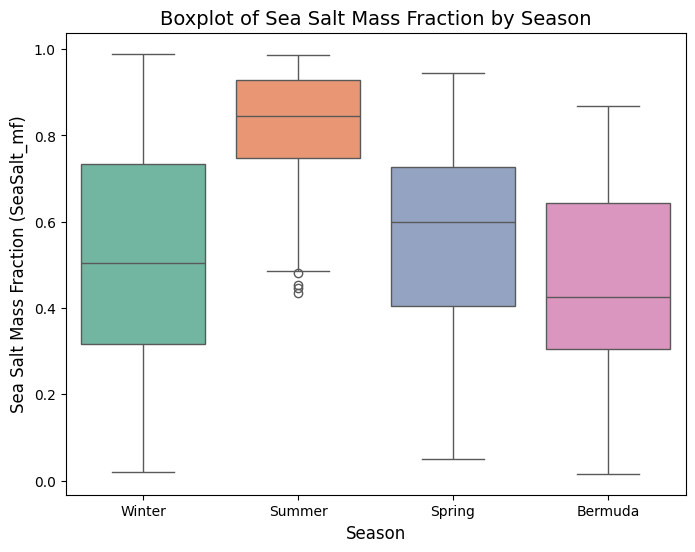

In [220]:
# Assuming 'd' is your DataFrame and it has a 'Season' column
# Create the boxplot
plt.figure(figsize=(8, 6))  # Set the figure size
sns.boxplot(x='Season', y='SeaSalt_mf', data=d, palette='Set2')  # Create the boxplot

# Add labels and title
plt.xlabel('Season', fontsize=12)
plt.ylabel('Sea Salt Mass Fraction (SeaSalt_mf)', fontsize=12)
plt.title('Boxplot of Sea Salt Mass Fraction by Season', fontsize=14)

# Show the plot
plt.show()

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_71438/1369245039.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Season', y='Ca_mf', data=d, palette='Set2', showfliers=False)  # Create the boxplot


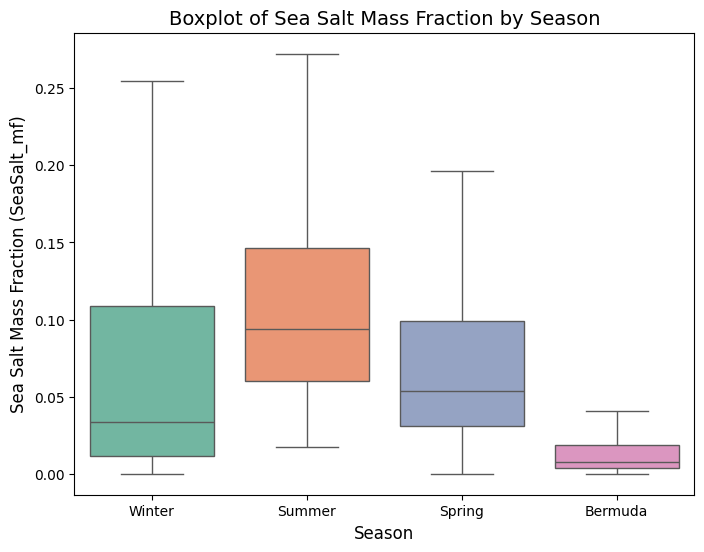

In [221]:
# Assuming 'd' is your DataFrame and it has a 'Season' column
# Create the boxplot
plt.figure(figsize=(8, 6))  # Set the figure size
sns.boxplot(x='Season', y='Ca_mf', data=d, palette='Set2', showfliers=False)  # Create the boxplot

# Add labels and title
plt.xlabel('Season', fontsize=12)
plt.ylabel('Sea Salt Mass Fraction (SeaSalt_mf)', fontsize=12)
plt.title('Boxplot of Sea Salt Mass Fraction by Season', fontsize=14)

# Show the plot
plt.show()

In [222]:
d['Oxalate'].min()

np.float64(0.0001934)

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_71438/4183841729.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Season', y='Oxalate', data=d, palette='Set2', showfliers=False)  # Create the boxplot


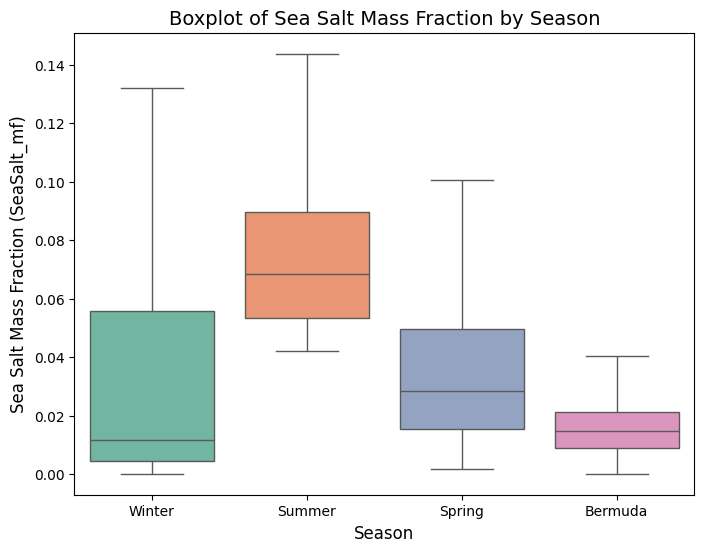

In [223]:
# Assuming 'd' is your DataFrame and it has a 'Season' column
# Create the boxplot
plt.figure(figsize=(8, 6))  # Set the figure size
sns.boxplot(x='Season', y='Oxalate', data=d, palette='Set2', showfliers=False)  # Create the boxplot

# Add labels and title
plt.xlabel('Season', fontsize=12)
plt.ylabel('Sea Salt Mass Fraction (SeaSalt_mf)', fontsize=12)
plt.title('Boxplot of Sea Salt Mass Fraction by Season', fontsize=14)

# Show the plot
plt.show()

In [224]:
'Sodium', 'Potassium', 'Magnesium', 'Calcium', 'Chloride', 'Nitrate', 'Sulfate', 'Oxalate', 'Ammonium'

('Sodium',
 'Potassium',
 'Magnesium',
 'Calcium',
 'Chloride',
 'Nitrate',
 'Sulfate',
 'Oxalate',
 'Ammonium')